In [ ]:
# Exercise 5. Explainable artificial intelligence in healthcare

/Users/aleksisormunen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


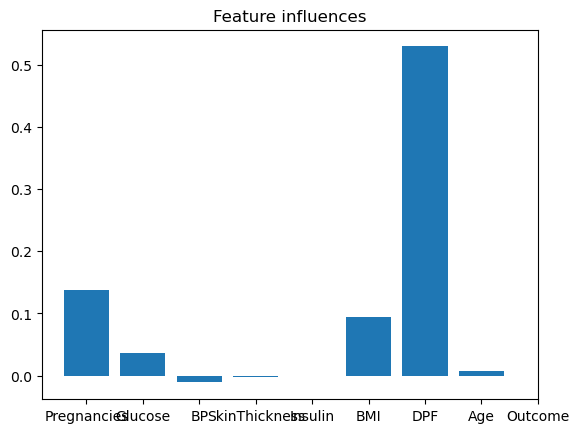

In [78]:
# 1. Explainability of transparent models
import pandas as pd
colnames = ['Pregnancies','Glucose','BP','SkinThickness','Insulin','BMI','DPF','Age','Outcome']
df = pd.read_csv('diabetes.csv', header = None, names = colnames, skiprows = 1)

#1.1 Variable coefficients
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

train, test = train_test_split(df, test_size=0.3, train_size = 0.7, random_state = 42, stratify = df['Outcome'])
X_train = train.drop('Outcome',axis=1)
y_train = train['Outcome'].copy()
X_test = test.drop('Outcome',axis=1)
y_test = test['Outcome'].copy()
lr_clf = LogisticRegression(random_state = 42, max_iter = 100).fit(X_train, y_train)
std_scaler = StandardScaler()
clf_pipe = Pipeline([('scaler', std_scaler), ('clf', lr_clf)])
importance = clf_pipe['clf'].coef_[0]
# Plotting bar chart
import_len = np.arange(len(importance))
fig = plt.figure()
plt.bar(import_len, importance)
plt.xticks(np.arange(len(colnames)),colnames)
plt.title('Feature influences')
plt.show()
# We can see from the bar blot that variable DiabetesPedigreeFunction has most influence to
# positive classification of diabetes. The least effect to positive classification
# of diabetes comes from Insulin variable.

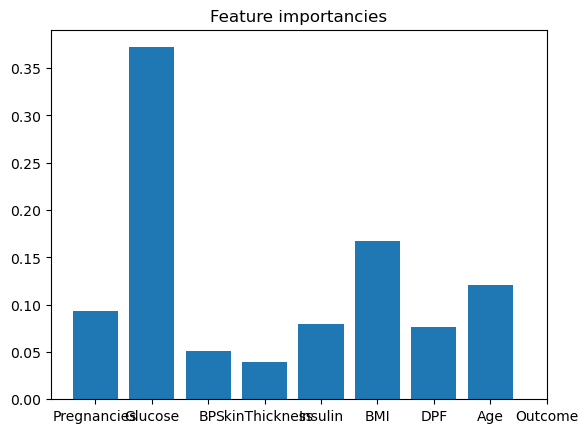

In [96]:
# 2. Explainability of black-box models
from sklearn.ensemble import RandomForestClassifier
# 2.1 Creating random forest classifier
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=8, min_samples_leaf=3, max_features=
'auto', bootstrap= True, random_state=42).fit(X_train, y_train)

# a) Implicit feature importance
importancies = rf_clf.feature_importances_
plt.bar(np.arange(len(importancies)),importancies)
plt.xticks(np.arange(len(colnames)),colnames)
plt.title('Feature importancies')
plt.show()
# We can see that most important feature is Glucose.

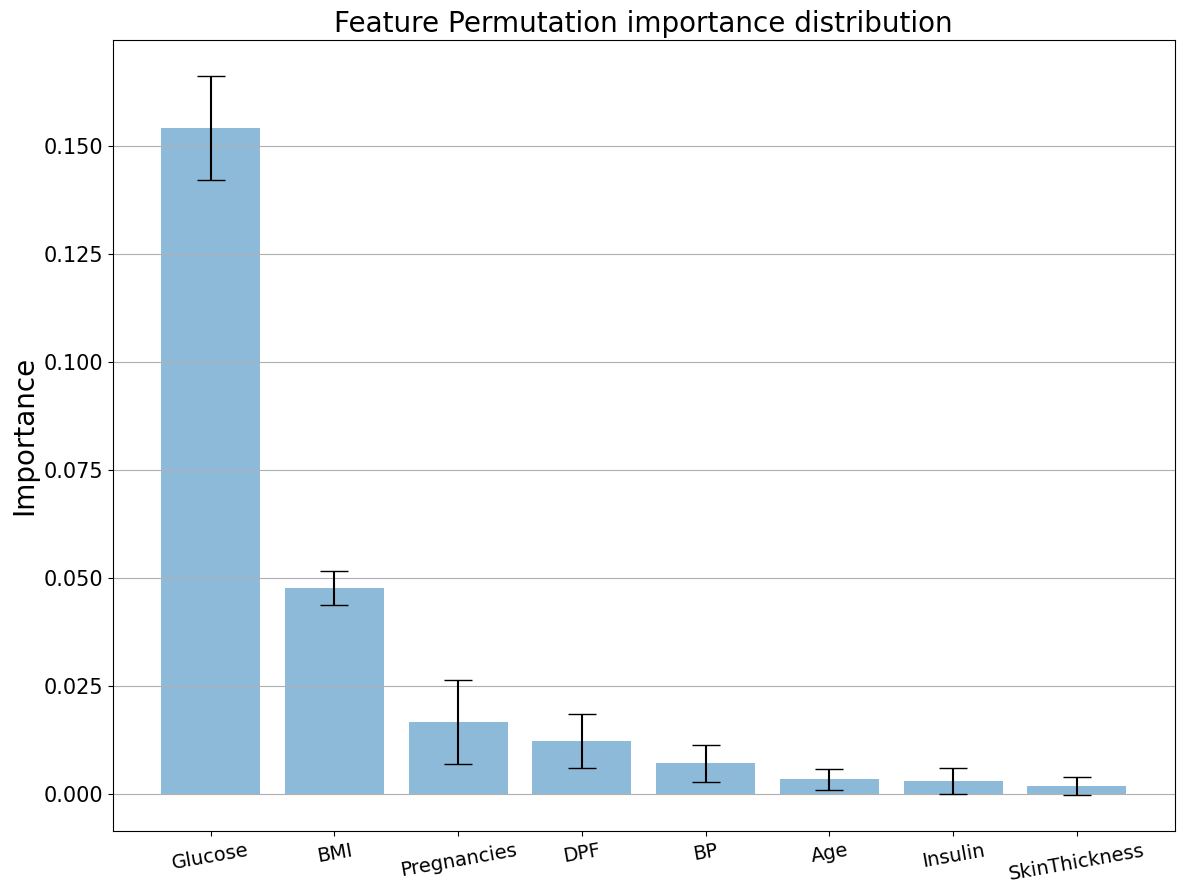

In [93]:
# b) Feature permutation importance
import eli5
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(clf_pipe['clf'], random_state=42).fit(X_train,y_train)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=colnames[0:8])
feat_perm_df.head(10)
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'],
align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'], fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=14, labelrotation=10)
ax.set_title('Feature Permutation importance distribution', fontsize=20)
ax.yaxis.grid(True)
# y-axis values shows importancies of features. Feature permutation figure
# measures the predictive value of the feature for classifier or regressor.

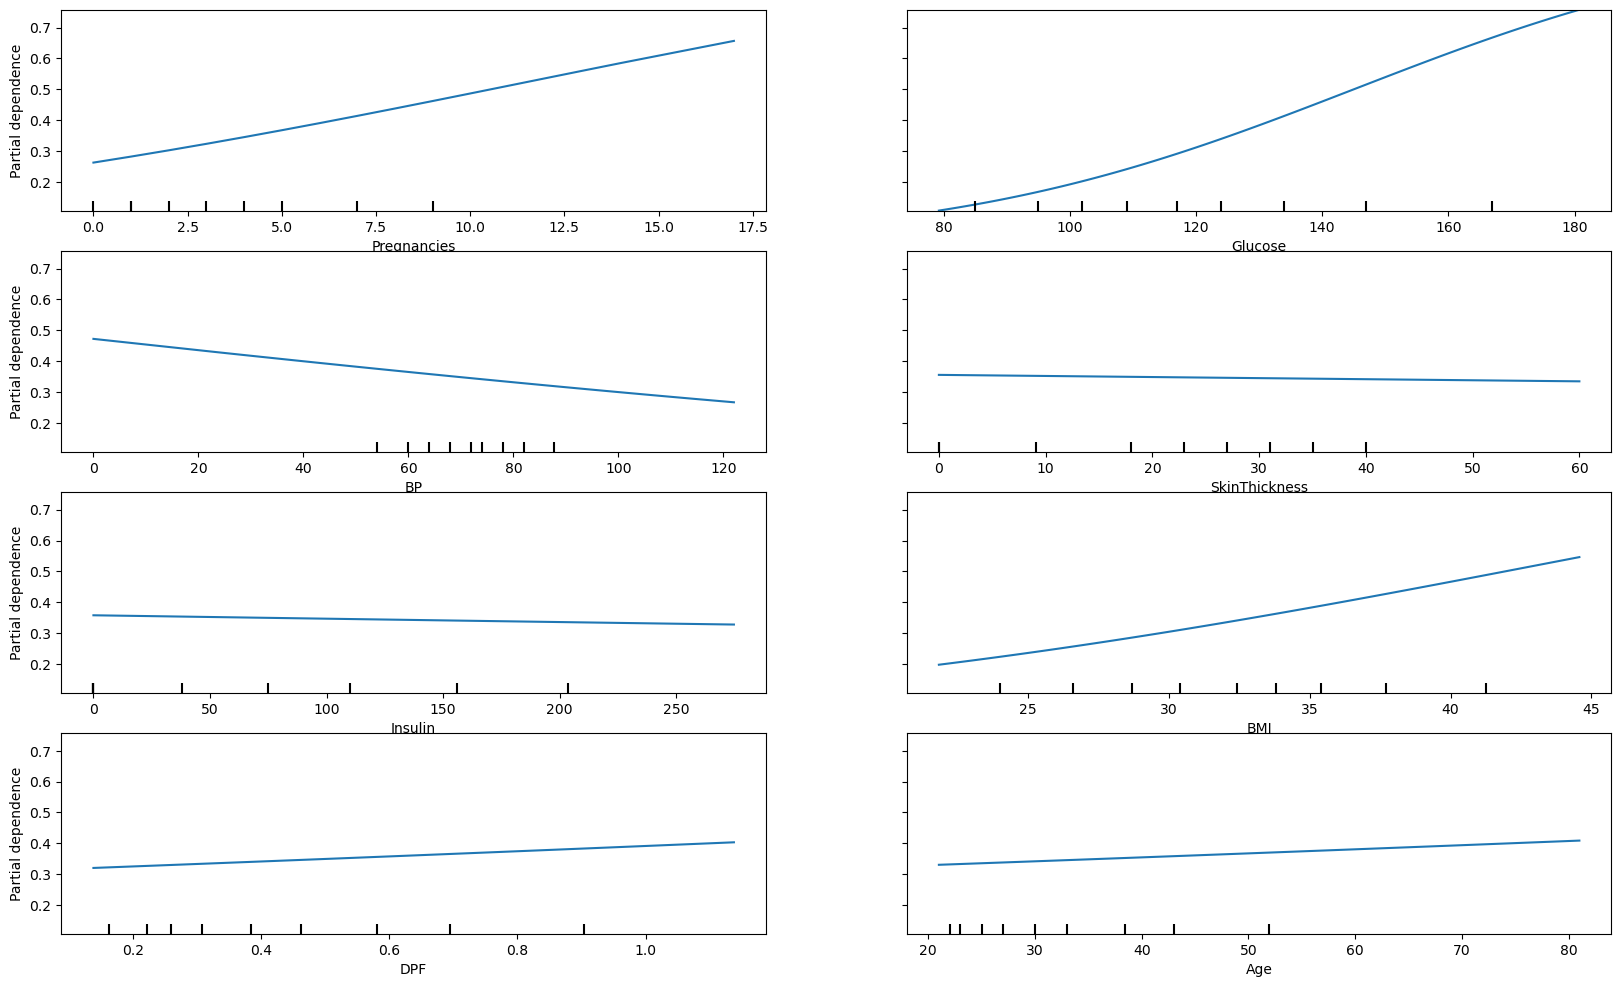

In [113]:
# c) Partial dependence plots
from sklearn.inspection import PartialDependenceDisplay
# 2.3 Depicting partial dependence plots
fig_train, (ax1,ax2,ax3,ax4) = plt.subplots(4, 2, figsize=(20, 12))
disp = PartialDependenceDisplay.from_estimator(perm, X_train, features = colnames[0:8], ax =(ax1,ax2,ax3,ax4))
# We can see from the plots the correlation of the certain feature in relation
# to the probability. For instance, glucose has rising linear curve. So, the higher glucose,
# the higher probability to have diabetes. We can see the probability dependencies for
# every feature by interpreting curves.

In [126]:
# 3. Explainability vs. Accuracy Trade-off
from sklearn.tree import DecisionTreeClassifier
# 3.1 Building a decision tree classifier, similar to random forest before
# and testing the accuracy with testing set.
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=8, min_samples_leaf=3, max_features=
'auto', random_state=42).fit(X_train,y_train)
pred = dt_clf.score(X_test, y_test)
print('Decision tree accurary with test set:', pred)

Decision tree accurary with test set: 0.7142857142857143


In [134]:
# 3.2 Depicting the tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt_clf, feature_names = colnames[0:8],
class_names = dt_clf.classes_.astype(str),filled=True,
rounded = True,special_characters=True) 
graph = graphviz.Source(dot_data)
graph.format = "png"
path = 'depicted_tree_'
file_name_dt = 'Diabetes_Decision_Tree'
graph.render(path+file_name_dt)
# We can see from the depicted tree that when gini index is zero (gini=0),
# then one way to end up with there is when, Preganancies<=6.5, DPF <= 0.318, Glucose <=161.5,
# BMI <= 45.35, BMI<=26.9 and finally wer get gini = 0.

'depicted_tree_Diabetes_Decision_Tree.png'